In [2]:
import runhouse as rh 
img = (
    rh.Image()
    .install_packages(
        [
            "tensorboard",
            "transformers",
            "accelerate",
            "scipy",
            "datasets",
            "s3fs",
            "torch",
        ]
    )
    .sync_secrets(["huggingface", "aws"])
)

num_nodes = 2
num_gpus_per_node = 4

# Requires access to a cloud account with the necessary permissions to launch compute.
cluster = rh.compute(
    name=f"rh-L4x{num_gpus_per_node}x{num_nodes}-2",
    num_nodes=num_nodes,
    instance_type=f"L4:{num_gpus_per_node}",
    provider="aws",
    # image=img,
    use_spot=False,
    autostop_mins=1000,
).up_if_not()


Output()

INFO | 2025-02-14 10:39:52 | runhouse.resources.hardware.cluster:2060 | Running command on rh-L4x4x2-2: echo "hello"


In [60]:
cluster.restart_server(resync_rh=False)

INFO | 2025-02-14 10:38:31 | runhouse.resources.hardware.cluster:2060 | Running command on rh-L4x4x2-2: echo "hello"
INFO | 2025-02-14 10:38:32 | runhouse.resources.hardware.cluster:1295 | Restarting Runhouse API server on rh-L4x4x2-2.
INFO | 2025-02-14 10:38:32 | runhouse.resources.hardware.cluster:660 | Using log level INFO on cluster's default env
INFO | 2025-02-14 10:38:32 | runhouse.resources.hardware.cluster:664 | Disabling observability on the cluster
INFO | 2025-02-14 10:38:32 | runhouse.resources.hardware.cluster:2060 | Running command on rh-L4x4x2-2: mkdir -p ~/.rh; touch ~/.rh/cluster_config.json; echo '{"name": "rh-L4x4x2-2", "resource_subtype": "OnDemandCluster", "den_auth": false, "server_port": 32300, "server_connection_type": "ssh", "server_host": null, "autostop_mins": 1000, "domain": null, "compute_properties": {"ips": ["18.208.176.5", "54.242.63.182"], "internal_ips": ["172.31.34.42", "172.31.44.100"], "cloud": "aws", "instance_type": "g6.12xlarge", "region": "us-eas

(0,
 'INFO | 2025-02-14 15:38:36 | runhouse.main:630 | Using port: 32300.\nINFO | 2025-02-14 15:38:36 | runhouse.main:642 | Setting api_server url to https://api.run.house\nINFO | 2025-02-14 15:38:36 | runhouse.main:663 | Starting API server using the following command: screen -dm bash -c "/home/ubuntu/miniconda3/bin/python3 -m runhouse.servers.http.http_server --port 32300 --api-server-url https://api.run.house --from-python 2>&1 | tee -a \'/home/ubuntu/.rh/server.log\' 2>&1".\nExecuting `pkill -f \x1b"/home/ubuntu/miniconda3/bin/python3 -m \x1b\n\x1brunhouse.servers.http.http_server"\x1b`\nExecuting `pkill -f \x1b".*ray.*6379.*"\x1b`\nExecuting `ray start --head --port \x1b6379\x1b --disable-usage-stats`\nUsage stats collection is disabled.\n\n\x1bLocal node IP\x1b: \x1b172.31.34.42\x1b\nTraceback (most recent call last):\n  File "/home/ubuntu/miniconda3/bin/ray", line 8, in <module>\n    sys.exit(main())\n  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/ray/scripts/scrip

In [3]:
from explore_embeddings import run_inference
remote_run_inference = rh.function(run_inference).to(cluster, name="run_inference")
trained_embeddings, base_embeddings = remote_run_inference(
    base_model="answerdotai/ModernBERT-base",
    trained_model_path = "./bert_output",
    dataset_path="./pubmed_processed/test.parquet",
    batch_size=32,  
    sample_rows = 128, 
)


INFO:datasets:PyTorch version 2.5.1 available.
INFO:datasets:TensorFlow version 2.18.0 available.


INFO | 2025-02-14 10:40:00 | runhouse.resources.hardware.ssh_tunnel:91 | Running forwarding command: ssh -T -L 32300:localhost:32300 -i ~/.ssh/sky-key -o Port=22 -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null -o LogLevel=ERROR -o IdentitiesOnly=yes -o ExitOnForwardFailure=yes -o ServerAliveInterval=5 -o ServerAliveCountMax=3 -o ConnectTimeout=30s -o ForwardAgent=yes -o ControlMaster=auto -o ControlPath=/tmp/skypilot_ssh_6ba66db0/6995fa3624/%C -o ControlPersist=300s ubuntu@18.208.176.5
INFO | 2025-02-14 10:40:02 | runhouse.resources.hardware.cluster:1599 | Rsyncing /Users/paulyang/runhouse/ to ~/runhouse/ on 18.208.176.5
INFO | 2025-02-14 10:40:03 | runhouse.resources.hardware.cluster:1599 | Rsyncing /Users/paulyang/runhouse/ to ~/runhouse/ on 54.242.63.182
INFO | 2025-02-14 10:40:05 | runhouse.resources.module:525 | Sending module run_inference of type <class 'runhouse.resources.functions.function.Function'> to rh-L4x4x2-2
INFO | 2025-02-14 10:40:05 | runhouse.servers.http

INFO:httpx:HTTP Request: POST http://127.0.0.1:32300/logs "HTTP/1.1 200 OK"


-----------
rh-L4x4x2-2
-----------
INFO | 2025-02-14 15:40:08 | datasets:58 | PyTorch version 2.6.0 available.
PyTorch version 2.6.0 available.
GPU 0 - Allocated Memory: 298.08 MB, Reserved Memory: 316.00 MB
batch
GPU 0 - Allocated Memory: 1458.20 MB, Reserved Memory: 14654.00 MB
batch
GPU 0 - Allocated Memory: 1458.20 MB, Reserved Memory: 18750.00 MB
batch
GPU 0 - Allocated Memory: 1458.20 MB, Reserved Memory: 18750.00 MB
batch
GPU 0 - Allocated Memory: 306.51 MB, Reserved Memory: 316.00 MB
batch
GPU 0 - Allocated Memory: 1458.51 MB, Reserved Memory: 14654.00 MB
batch


In [24]:
cluster.delete('run_inference')

['run_inference']

In [59]:
cluster.config()


{'name': 'rh-L4x4x2-2',
 'resource_type': 'cluster',
 'resource_subtype': 'OnDemandCluster',
 'visibility': 'private',
 'server_port': 32300,
 'server_connection_type': 'ssh',
 'den_auth': False,
 'ssh_port': 22,
 'client_port': 32300,
 'ssh_properties': {'ssh_user': 'ubuntu',
  'ssh_private_key': '~/.ssh/sky-key',
  'ssh_control_name': 'rh-l4x4x2-2-6ba6',
  'ssh_proxy_command': None},
 'creds': {'name': 'ssh-sky-key',
  'resource_type': 'secret',
  'resource_subtype': 'SkySecret',
  'visibility': 'private',
  'provider': 'sky',
  'path': '~/.ssh/sky-key'},
 'instance_type': 'L4:4',
 'num_nodes': 2,
 'provider': 'aws',
 'use_spot': False,
 'launcher': 'local',
 'compute_properties': {'ips': ['18.208.176.5', '54.242.63.182'],
  'internal_ips': ['172.31.34.42', '172.31.44.100'],
  'cloud': 'aws',
  'instance_type': 'g6.12xlarge',
  'region': 'us-east-1',
  'cost_per_hour': '4.6016',
  'disk_size': 256,
  'memory': None,
  'num_cpus': '48.0',
  'gpus': {'L4': 4}},
 'autostop_mins': 1000,


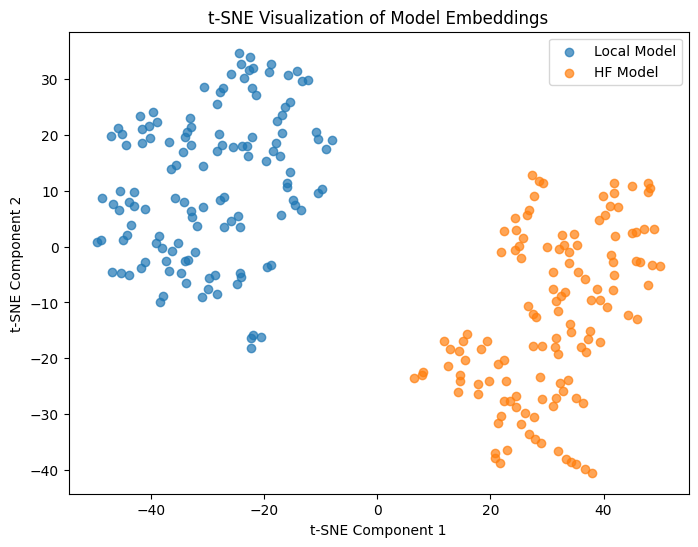

In [43]:
# Apply t-SNE
import numpy as np 
embeddings_combined = np.vstack([trained_embeddings, base_embeddings])
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_combined)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[: len(trained_embeddings), 0], embeddings_2d[: len(trained_embeddings), 1], label="Local Model", alpha=0.7)
plt.scatter(embeddings_2d[len(trained_embeddings) :, 0], embeddings_2d[len(trained_embeddings) :, 1], label="HF Model", alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Model Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


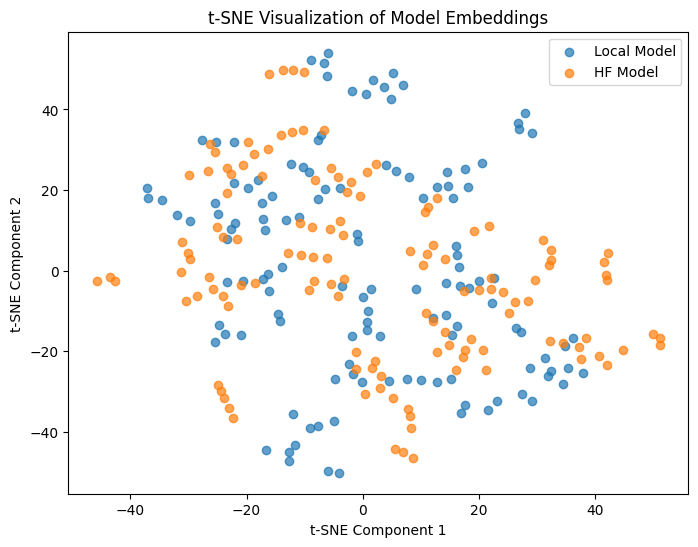

In [47]:
# Apply t-SNE
import numpy as np 
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
embeddings_2d_base = tsne.fit_transform(base_embeddings)
embeddings_2d_trained = tsne.fit_transform(trained_embeddings)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d_trained[: , 0], embeddings_2d_trained[:, 1], label="Local Model", alpha=0.7)
plt.scatter(embeddings_2d_base[ :, 0], embeddings_2d_base[ :, 1], label="HF Model", alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Model Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [31]:
trained_embeddings_normalized

array([[-0.02075894,  0.00344319,  0.02415223, ..., -0.06227683,
         0.03353368,  0.02365322],
       [-0.00917355,  0.02512754,  0.02712179, ..., -0.04187924,
         0.01376032,  0.01864623],
       [-0.02263068,  0.00798135,  0.04344282, ..., -0.0505149 ,
         0.01515447,  0.00959783],
       ...,
       [ 0.00084352,  0.02858044,  0.05239747, ..., -0.04346608,
         0.02500788, -0.00379584],
       [-0.01759779,  0.00062622,  0.02543033, ..., -0.05655706,
         0.04902969,  0.01103676],
       [ 0.00953383,  0.01049736,  0.00507119, ..., -0.05192896,
         0.03570116,  0.01460502]], dtype=float32)